In [0]:
import os
from os.path import join, dirname, exists
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision import transforms as transforms
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import collections

def savefig(fname, show_figure=True):
    if not exists(dirname(fname)):
        os.makedirs(dirname(fname))
    plt.tight_layout()
    plt.savefig(fname)
    if show_figure:
        plt.show()

def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    return train_data, test_data

def visualize_mnist_data():
    train_data, _ = load_mnist_data()
    imgs = train_data.data[:100]
    show_samples(imgs.reshape([100, 28, 28, 1]) * 255.0, title=f'MNIST samples')

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

In [0]:
# GPU Wrapper to make a better world
_use_gpu = True
DEVICE = torch.device("cuda:0")
_gpu_id = 0

def set_gpu_mode(mode, gpu_id=0):
    global _use_gpu
    global DEVICE
    global _gpu_id
    _gpu_id = gpu_id
    _use_gpu = mode
    DEVICE = torch.device("cuda:" + str(gpu_id) if _use_gpu else "cpu")

def FloatTensor(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.FloatTensor(*args, **kwargs).to(torch_device)

def get_numpy(tensor):
    return tensor.to('cpu').detach().numpy()

def zeros(*sizes, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.zeros(*sizes, **kwargs, device=torch_device)


def ones(*sizes, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.ones(*sizes, **kwargs, device=torch_device)


def ones_like(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.ones_like(*args, **kwargs, device=torch_device)

def zeros_like(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.zeros_like(*args, **kwargs, device=torch_device)


def tensor(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.tensor(*args, **kwargs, device=torch_device)

def normal(*args, **kwargs):
    return torch.normal(*args, **kwargs).to(DEVICE)

In [0]:
def plot_gan_training(losses, title, fname):
    plt.figure()
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.plot(xs, losses, label='loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    savefig(fname)

def plot_gan_supervised(pretrained_losses, random_losses, title, fname):
    plt.figure()
    xs = np.arange(len(pretrained_losses))
    plt.plot(xs, pretrained_losses, label='bigan')
    xs = np.arange(len(random_losses))
    plt.plot(xs, random_losses, label='random init')
    plt.legend()
    plt.title(title)
    savefig(fname)

def bigan_save_results(fn):
    train_data, test_data = load_mnist_data()
    gan_losses, samples, reconstructions, pretrained_losses, random_losses = fn(train_data, test_data)

    plot_gan_training(gan_losses, 'BiGAN Losses', 'results/bigan_losses.png')
    plot_gan_supervised(pretrained_losses, random_losses, 'Linear classification losses', 'results/bigan_supervised_losses.png')
    show_samples(samples * 255.0, fname='results/bigan_samples.png', title='BiGAN generated samples')
    show_samples(reconstructions * 255.0, nrow=20, fname='results/BiGAN_reconstructions.png', title=f'BiGAN reconstructions')
    print('BiGAN final linear classification loss:', pretrained_losses[-1])
    print('Random encoder linear classification loss:', random_losses[-1])

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




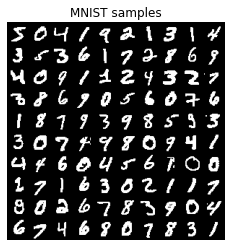

In [0]:
visualize_mnist_data()

In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(g_input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.fc(x).reshape(x.shape[0], 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, z_dim, x_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim + x_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
    
    def forward(self, z, x):
        x = torch.cat((z, x), dim=1)
        return self.fc(x)

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc(x)

In [0]:
class Trainer(object):
    def __init__(self, train_data, test_data, n_epochs=100, batch_size=128, latent_dim=50):
        self.log_interval = 100
        self.batch_size = batch_size
        self.train_loader, self.test_loader = self.create_loaders(train_data, test_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = n_epochs
        self.curr_itr = 0
        self.latent_dim = latent_dim
    
    def build(self):
        self.d = Discriminator(self.latent_dim, 784).to(DEVICE)
        self.e = Encoder(784, self.latent_dim).to(DEVICE)
        self.g = Generator(self.latent_dim, 784).to(DEVICE)
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(self.d_optimizer, lambda epoch: (self.n_epochs - epoch) / self.n_epochs)
        self.g_optimizer = torch.optim.Adam(list(self.e.parameters())+list(self.g.parameters()), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer, lambda epoch: (self.n_epochs - epoch)/self.n_epochs)
        self.linear = nn.Linear(self.latent_dim, 10).to(DEVICE)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)
    
    def reset_linear(self):
        self.linear = nn.Linear(self.latent_dim, 10).to(DEVICE)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)
    
    def create_loaders(self, train_data, test_data):
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        return train_loader, test_loader

    def get_discriminator_loss(self, x):
        z_fake = torch.normal(torch.zeros(x.shape[0], self.latent_dim), torch.ones(x.shape[0], self.latent_dim)).to(DEVICE)
        z_real = self.e(x).reshape(x.shape[0], self.latent_dim)
        x_fake = self.g(z_fake).reshape(x.shape[0], -1)
        x_real = x.view(x.shape[0], -1)

        d_loss = - 0.5 * (self.d(z_real, x_real)).log().mean() - 0.5 * (1 - self.d(z_fake, x_fake)).log().mean()
        return d_loss
    
    def train_bigan(self):
        train_losses = []
        val_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch'):
            epoch_i += 1
            self.d.train()
            self.g.train()
            self.e.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(DEVICE).float()

                self.d_optimizer.zero_grad()
                d_loss = self.get_discriminator_loss(x)
                d_loss.backward()
                self.d_optimizer.step()

                self.g_optimizer.zero_grad()
                g_loss = -self.get_discriminator_loss(x)
                g_loss.backward()
                self.g_optimizer.step()

                self.batch_loss_history.append(d_loss.item())
            
            self.g_scheduler.step()
            self.d_scheduler.step()
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            self.save_samples(100, f'epoch{epoch_i}_samples.png')
        
        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.py')
        train_losses = np.array(train_losses)

        return train_losses
    
    def train_linear_classifier(self):
        train_losses = []
        val_accs = []
        for epoch_i in tqdm_notebook(range(self.n_epochs // 2), desc='Epoch'):
            epoch_i += 1
            self.e.eval()
            self.linear.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(DEVICE).float()
                y = y.to(DEVICE)

                self.linear_optimizer.zero_grad()
                z = self.e(x).detach()
                pred = self.linear(z)
                linear_loss = F.cross_entropy(pred, y)
                linear_loss.backward()
                self.linear_optimizer.step()

                self.batch_loss_history.append(linear_loss.item())
            
            val_acc = self.val_acc()
            val_accs.append(val_acc)
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
        
        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')
        train_losses = np.array(train_losses)
        val_accs = np.array(val_accs)
        return train_losses, val_accs
    
    def sample(self, n):
        self.g.eval()
        with torch.no_grad():
            z = (torch.rand(n, self.latent_dim).to(DEVICE) - 0.5) * 2
            samples = self.g(z).reshape(-1, 1, 28, 28)
        return get_numpy(samples)
    
    def save_samples(self, n, filename):
        self.g.eval()
        with torch.no_grad():
            z = (torch.rand(n ,self.latent_dim).to(DEVICE) - 0.5) * 2
            samples = self.g(z).reshape(-1, 1, 28, 28) * 0.5 + 1
            save_image(samples, filename, nrow=10, normalize=True)
    def get_reconstructions(self, x):
        self.g.eval()
        self.e.eval()
        with torch.no_grad():
            z = self.e(x)
            recons = self.g(z).reshape(-1, 1, 28, 28)
        return get_numpy(recons)
    
    def val_acc(self):
        self.e.eval()
        self.linear.eval()
        val_acc_total = 0
        val_items = 0
        with torch.no_grad():
            for (inputs, labels) in self.test_loader:
                inputs = inputs.to(DEVICE).float()
                z = self.e(inputs)
                labels = labels.to(DEVICE)
                logits = self.linear(z)
                predictions = torch.argmax(logits, dim=1)
                num_correct = torch.sum(predictions == labels).float()
                val_acc_total += num_correct
                val_items += inputs.shape[0]
        
        return get_numpy(val_acc_total / val_items)
    
    def save_models(self, filename):
        torch.save(self.g.state_dict(), "g_"+filename)
        torch.save(self.d.state_dict(), "d_"+filename)
        torch.save(self.e.state_dict(), "e_"+filename)
    
    def load_models(self, filename):
        self.g.load_state_dict(torch.load("g_"+filename))
        self.d.load_state_dict(torch.load("d_"+filename))
        self.e.load_state_dict(torch.load("e_"+filename))

In [0]:

def bigan_fn(train_data, test_data):
    trainer = Trainer(train_data, test_data, n_epochs=100)
    trainer.build()

    print("Training linear classifier on random encoder")
    train_losses, val_accs = trainer.train_linear_classifier()

    print("Training BiGAN")
    bigan_losses = trainer.train_bigan()
    samples = trainer.sample(100).transpose(0, 2, 3, 1) * 0.5 + 0.5
    train_images = train_data.data[:20].reshape(20, 1, 28, 28) / 255.0
    train_img_tensor = FloatTensor(train_images) * 2 - 1
    recons = trainer.get_reconstructions(train_img_tensor) * 0.5 + 0.5

    trainer.reset_linear()
    print("Training linear classifier on BiGAN encoder")
    bigan_train_losses, bigan_val_accs = trainer.train_linear_classifier()

    print(f"Final BiGAN test linear accuracy: {bigan_val_accs[-1]}")
    print(f"Final random encoder test linear accuracy: {val_accs[-1]}")

    return bigan_losses, samples, np.concatenate([train_images, recons], axis=0).transpose(0, 2, 3, 1), bigan_train_losses, train_losses

Training linear classifier on random encoder



Training BiGAN



Training linear classifier on BiGAN encoder



Final BiGAN test linear accuracy: 0.8562999963760376
Final random encoder test linear accuracy: 0.8003000020980835


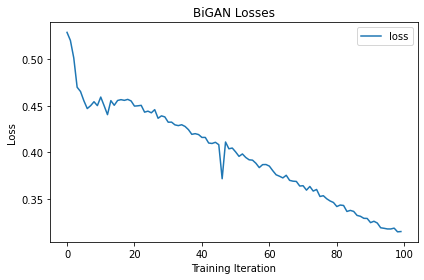

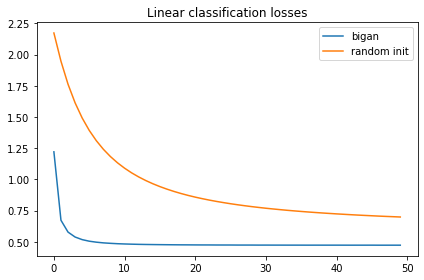

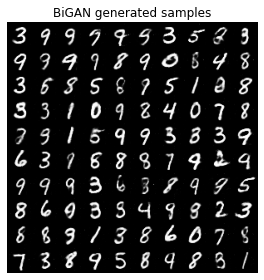

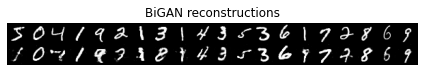

BiGAN final linear classification loss: 0.47385683569953896
Random encoder linear classification loss: 0.6994933804342234


In [0]:
bigan_save_results(bigan_fn)

In [0]:
train_data, test_data = load_mnist_data()
linear = nn.Linear(784, 10).to(DEVICE)
linear_optimizer = torch.optim.Adam(linear.parameters(), lr=1e-3)
def val_acc(linear, test_data):
    linear.eval()
    val_acc_total = 0
    val_items = 0
    with torch.no_grad():
        for (inputs, labels) in test_data:
            z = inputs.view(inputs.shape[0], -1).to(DEVICE).float()
            labels = labels.to(DEVICE)
            logits = linear(z)
            predictions = torch.argmax(logits, dim=1)
            num_correct = torch.sum(predictions == labels).float()
            val_acc_total += num_correct
            val_items += inputs.shape[0]
    
    return get_numpy(val_acc_total / val_items)
def train_linear_classifier(n_epochs, linear, linear_optimizer, train_data, test_data):
    train_losses = []
    val_accs = []
    for epoch_i in tqdm_notebook(range(n_epochs // 2), desc='Epoch'):
        epoch_i += 1
        linear.train()
        batch_loss_history = []
        for batch_i, (x, y) in enumerate(tqdm_notebook(train_data, desc='Batch', leave=False)):
            batch_i += 1
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            linear_optimizer.zero_grad()
            z = inputs.view(inputs.shape[0], -1).to(DEVICE).float().detach()
            pred = linear(z)
            linear_loss = F.cross_entropy(pred, y)
            linear_loss.backward()
            linear_optimizer.step()
            batch_loss_history.append(linear_loss.item())
        
        val_acc_ = val_acc(linear, test_data)
        val_accs.append(val_acc_)
        epoch_loss = np.mean(batch_loss_history)
        train_losses.append(epoch_loss)

    train_losses = np.array(train_losses)
    val_accs = np.array(val_accs)
    return train_losses, val_accs

In [0]:
train_linear_classifier(100, linear, linear_optimizer, train_data, test_data)

AttributeError: ignored

In [0]:
for (x, y) in train_data:
    print(x)
    print(y)
    break

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1